In [6]:
from sys import path as syspath
from pathlib import Path

%matplotlib widget

syspath.append(str(Path().home() / "pyref" / "src"))

In [7]:
import pyref as rf
from pypxr.structure import PXR_SLD, PXR_MaterialSLD, PXR_Slab
from pypxr.reflectivity import PXR_ReflectModel
from refnx.analysis import Transform, CurveFitter, Objective, GlobalObjective
from refnx._lib.emcee.moves.de import DEMove

# Experimental Configuration

In this notebook, we play arround with the idea that that the experiment could change in configuration between collecting s and p polarizaed data. Thus we will fit seperately s and p pol data and compare the results. 

In [8]:
%%html
<style>
.cell-output-ipywidget-background {
   background-color: transparent !important;
}
.jp-OutputArea-output {
   background-color: transparent;
}
</style>

C:\Users\hduva\AppData\Local\Temp\ipykernel_13380\2947207326.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s_pol = _s_pol[(_s_pol["Q"] != 0.0757)][_s_pol["Q"] != 0.0740]
C:\Users\hduva\AppData\Local\Temp\ipykernel_13380\2947207326.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  p_pol = _p_pol[(_p_pol["Q"] != 0.0757)][_p_pol["Q"] != 0.0740]


<Axes: xlabel='Q'>

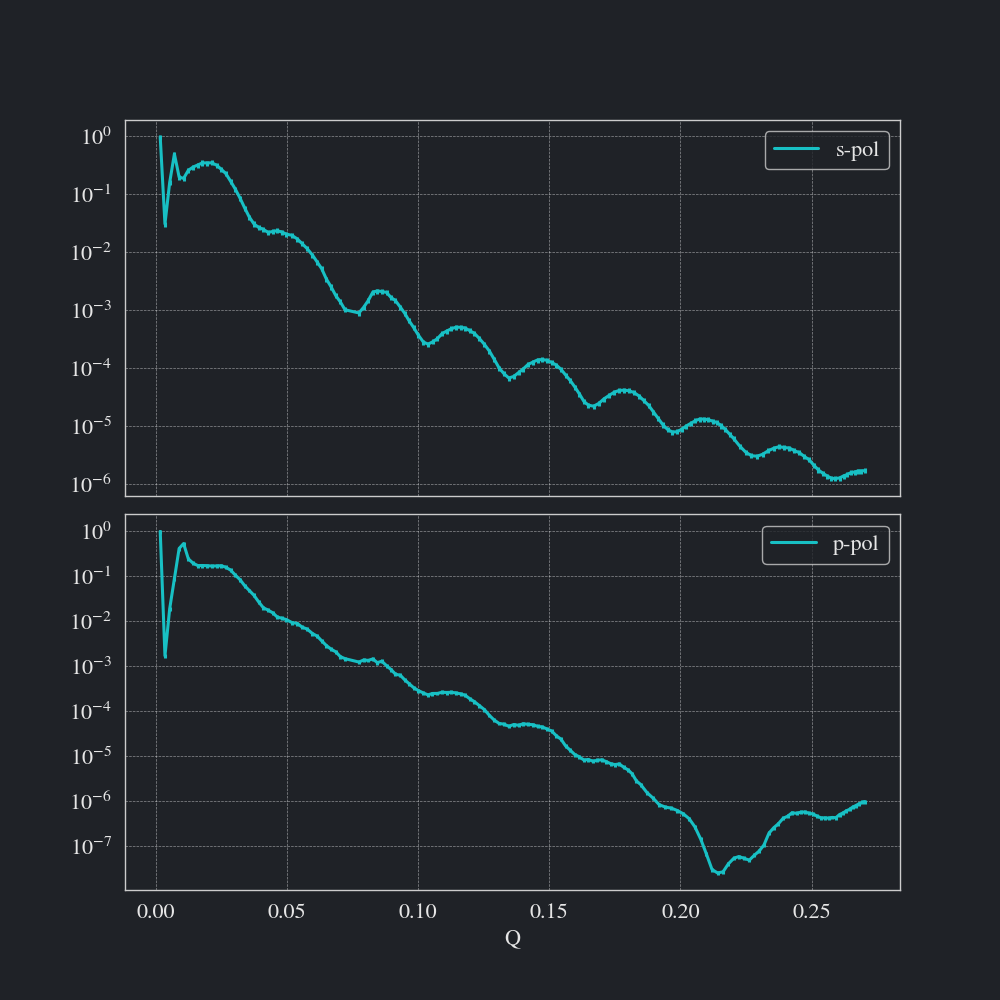

In [9]:
import matplotlib.pyplot as plt

db = rf.db()

# ------------------------------------------------
# Load data
# Data loading is focused on the 283.7 ev data set
# ------------------------------------------------

_s_pol = db.get_refl("ZnPc_283.7_100.0 (CCD Scan 82865).parquet", "ZnPc")
_p_pol = db.get_refl("ZnPc_283.7_190.0 (CCD Scan 82869).parquet", "ZnPc")

s_pol = _s_pol[(_s_pol["Q"] != 0.0757)][_s_pol["Q"] != 0.0740]
p_pol = _p_pol[(_p_pol["Q"] != 0.0757)][_p_pol["Q"] != 0.0740]

# ------------------------------------------------
# Plot data
# ------------------------------------------------

fig, ax = plt.subplots(
    2, 1, figsize=(10, 10), sharex=True, gridspec_kw={"hspace": 0.05}
)
s_pol.plot(ax=ax[0], label="s-pol", x="Q", y="Refl", yerr="Err", logy=True)
p_pol.plot(ax=ax[1], label="p-pol", x="Q", y="Refl", yerr="Err", logy=True)

In [10]:
# Collect structure parameters
znpc_mono_struct_file = db.get_struct("ZnPc_RoomTemp")
znpc_oc = db.get_oc("C32H16N8Zn")

si_thick = znpc_mono_struct_file["Si"]["thickness"]
si_rough = znpc_mono_struct_file["Si"]["roughness"]
si_density = znpc_mono_struct_file["Si"]["density"]

sio2_thick = znpc_mono_struct_file["SiO2"]["thickness"]
sio2_rough = znpc_mono_struct_file["SiO2"]["roughness"]
sio2_density = znpc_mono_struct_file["SiO2"]["density"]

c_amor_thick = znpc_mono_struct_file["C"]["thickness"]
c_amor_rough = znpc_mono_struct_file["C"]["roughness"]
c_amor_density = znpc_mono_struct_file["C"]["density"]

znpc_thick = znpc_mono_struct_file["C32H16N8Zn"]["thickness"]
znpc_rough = znpc_mono_struct_file["C32H16N8Zn"]["roughness"]
znpc_density = znpc_mono_struct_file["C32H16N8Zn"]["density"]

In [11]:
from typing import Any, Generator, Literal
from numpy import ndarray


ens = [283.7, 283.7]

type _bound = tuple[float, float]
type complex_bound = dict[Literal["r", "i"], _bound]
type bound = dict[Literal["xx", "zz"], complex_bound]


def n_limits(ens, density) -> tuple[list[bound], list[ndarray]]:
    ns = znpc_oc(ens, density=density)
    bounds: list[complex_bound] = []
    if not isinstance(ns, list):
        ns = [ns]
    for n in ns:
        xx = n[0]
        zz = n[1]
        xx_r: _bound = (xx.real, -.15e-4) if xx.real < 0 else (.15e-4, xx.real)
        zz_r: _bound = (zz.real, -.15e-4) if zz.real < 0 else (.15e-4, zz.real)
        xx_i: _bound = (xx.imag, -.15e-4) if xx.imag < 0 else (.15e-4, xx.imag)
        zz_i: _bound = (zz.imag, -.15e-4) if zz.imag < 0 else (.15e-4, zz.imag)
        xx_bound: complex_bound = {"r": xx_r, "i": xx_i}
        zz_bound: complex_bound = {"r": zz_r, "i": zz_i}
        bounds.append({"xx": xx_bound, "zz": zz_bound})
    return bounds, ns


bounds, ns = n_limits(ens, znpc_density)

________________________________________________________________________________
Parameters: 'Structure - ' 
________________________________________________________________________________
Parameters:       ''       
<Parameter:   '_thick'    , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:     'rho'     , value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:   '_rough'    , value=0  (fixed) , bounds=[-inf, inf]>
________________________________________________________________________________
Parameters:   'ZnPc_surf'  
<Parameter:'ZnPc_surf_thick', value=10  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_diso', value=-0.00116558  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_biso', value=0.000507302  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_enOffset', value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_xx' , value=0.00049552  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_ixx', value=0.00020495  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_surf_

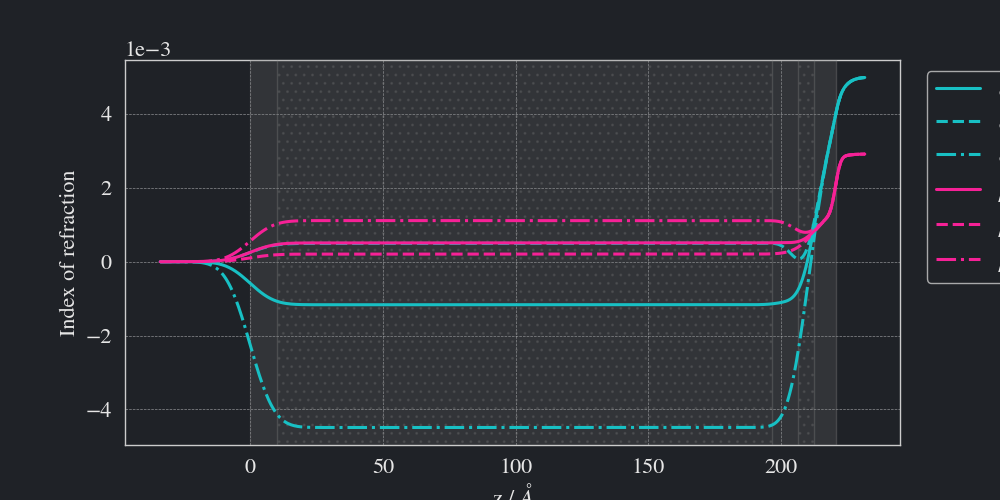

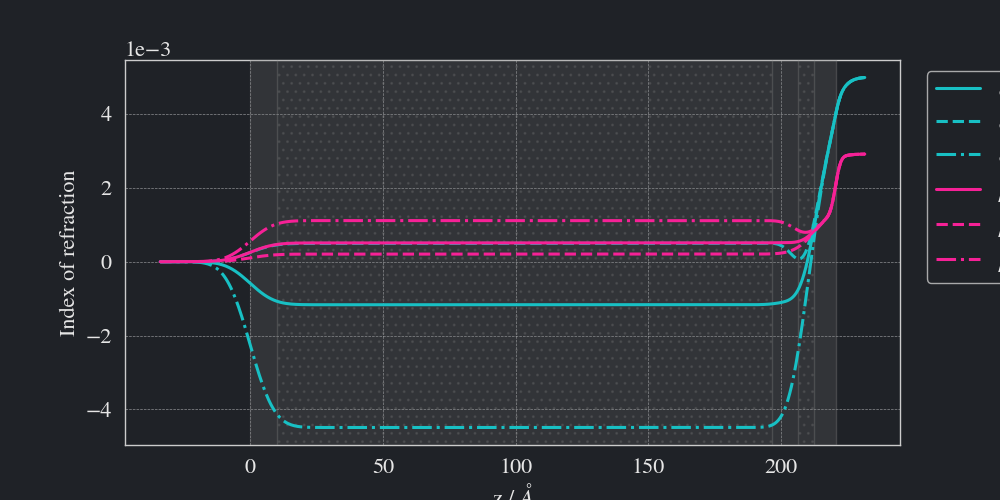

In [18]:
from numpy import asarray

plt.close("all")

vac = [PXR_MaterialSLD("", 0, en)(0, 0) for en in ens]
si = [PXR_MaterialSLD("Si", 2.33, en, name="Si")(si_thick, si_rough) for en in ens]
sio2 = [
    PXR_MaterialSLD("SiO2", sio2_density, en, name="SiO2")(sio2_thick, sio2_rough)
    for en in ens
]
c_amor = [
    PXR_MaterialSLD("C", c_amor_density, en, name="C_Amorphous")(
        c_amor_thick, c_amor_rough
    )
    for en in ens
]

znpc_surf_thick = 10
znpc = [
    PXR_SLD(n, symmetry="uni", name="ZnPc")(
        znpc_thick - znpc_surf_thick, znpc_rough / 2
    )
    for n in ns
]

znpc_surf = [
    PXR_SLD(n, symmetry="uni", name="ZnPc_surf")(znpc_surf_thick, znpc_rough)
    for n in ns
]

znpc_sub = [
    PXR_SLD(n, symmetry="uni", name="ZnPc_sub")(znpc_surf_thick, znpc_rough)
    for n in ns
]
structs = [
    vac[i] | znpc_surf[i] | znpc[i] | znpc_sub[i] | c_amor[i] | sio2[i] | si[i]
    for i in range(len(ens))
]

for struc in structs:
    struc.plot()
    print(struc.parameters)

In [20]:
# ------------------------------------------------
# Constrain Model
# ------------------------------------------------

# Independent of polarization
from numpy import array


for slab in si:
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)

for slab in sio2:
    slab.thick.setp(vary=None, constraint=sio2_thick)
    slab.rough.setp(vary=None, constraint=sio2_rough)
    slab.sld.density.setp(vary=True, bounds=slab.sld.density.value * array([0.8, 1.2]))

for slab in c_amor:
    slab.thick.setp(vary=None, constraint=c_amor_thick)
    slab.rough.setp(vary=None, constraint=c_amor_rough)
    slab.sld.density.setp(vary=True, bounds=slab.sld.density.value * array([0.8, 1.2]))


def sld_constraint(
    slab: PXR_Slab,
    bounds: bound | None = None,
    xx_bounds: _bound = (-0.005, 0.005),
    zz_bounds: _bound = (-0.005, 0.005),
):
    if bounds is None:
        bounds = {"xx": {"r": xx_bounds, "i": xx_bounds}, "zz": {"r": zz_bounds, "i": zz_bounds}}
    print(slab.parameters)
    slab.sld.xx.setp(vary=True, bounds=bounds["xx"]["r"])
    slab.sld.zz.setp(vary=True, bounds=bounds["zz"]["r"])
    slab.sld.ixx.setp(vary=True, bounds=bounds["xx"]["i"])
    slab.sld.izz.setp(vary=True, bounds=bounds["zz"]["i"])
    slab.thick.setp(vary=True, bounds=slab.thick.value * array([0.8, 1.2]))
    slab.rough.setp(vary=True, bounds=slab.rough.value * array([0.8, 1.2]))
    print(slab.sld.parameters)

In [21]:

sld_constraint(znpc[0], bounds[0])
# sld_constraint(znpc[1], bounds[1])
znpc[1].sld.symmetry="iso"
sld_constraint(znpc_surf[0], xx_bounds=(-.005, .003), zz_bounds=(-.005, .003))
# sld_constraint(znpc_surf[1], xx_bounds=(-.005, .003), zz_bounds=(-.005, .003))
znpc_surf[1].sld.symmetry="iso"
sld_constraint(znpc_sub[0], xx_bounds=(-.005, .003), zz_bounds=(-.005, .003))
# sld_constraint(znpc_sub[1], xx_bounds=(-.005, .003), zz_bounds=(-.005, .003))
znpc_sub[1].sld.symmetry="iso"

for i, slab in enumerate(znpc):
    slab.thick.setp(vary=False, constraint = znpc_thick - znpc_surf[i].thick.value - znpc_sub[i].thick.value)

# znpc[1].sld.xx.setp(vary=False, constraint=znpc[0].sld.xx.value)
# znpc[1].sld.izz.setp(vary=False, constraint=znpc[0].sld.izz.value)
znpc[1].rough.setp(vary=False, constraint=znpc[0].rough.value)

# ------------------------------------------------

# znpc_surf[1].sld.xx.setp(vary=False, constraint=znpc_surf[0].sld.xx.value)
# znpc_surf[1].sld.izz.setp(vary=False, constraint=znpc_surf[0].sld.izz.value)
znpc_surf[1].thick.setp(vary=False, constraint=znpc_surf[0].thick.value)
znpc_surf[1].rough.setp(vary=False, constraint=znpc_surf[0].rough.value)

# ------------------------------------------------

# znpc_sub[1].sld.xx.setp(vary=False, constraint=znpc_sub[0].sld.xx.value)
# znpc_sub[1].sld.izz.setp(vary=False, constraint=znpc_sub[0].sld.izz.value)
znpc_sub[1].thick.setp(vary=False, constraint=znpc_sub[0].thick.value)
znpc_sub[1].rough.setp(vary=False, constraint=znpc_sub[0].rough.value)

________________________________________________________________________________
Parameters:     'ZnPc'     
<Parameter: 'ZnPc_thick'  , value=186.441  (fixed) , bounds=[-inf, inf]>
<Parameter:  'ZnPc_diso'  , value=-0.00116558  (fixed) , bounds=[-inf, inf]>
<Parameter:  'ZnPc_biso'  , value=0.000507302  (fixed) , bounds=[-inf, inf]>
<Parameter:'ZnPc_enOffset', value=0  (fixed) , bounds=[-inf, inf]>
<Parameter:   'ZnPc_xx'   , value=0.00049552  (fixed) , bounds=[-inf, inf]>
<Parameter:  'ZnPc_ixx'   , value=0.00020495  (fixed) , bounds=[-inf, inf]>
<Parameter:   'ZnPc_yy'   , value=0.00049552          , bounds=[-inf, inf], constraint=<Parameter:   'ZnPc_xx'   , value=0.00049552  (fixed) , bounds=[-inf, inf]>>
<Parameter:  'ZnPc_iyy'   , value=0.00020495          , bounds=[-inf, inf], constraint=<Parameter:  'ZnPc_ixx'   , value=0.00020495  (fixed) , bounds=[-inf, inf]>>
<Parameter:   'ZnPc_zz'   , value=-0.00448779  (fixed) , bounds=[-inf, inf]>
<Parameter:  'ZnPc_izz'   , value=0.0011

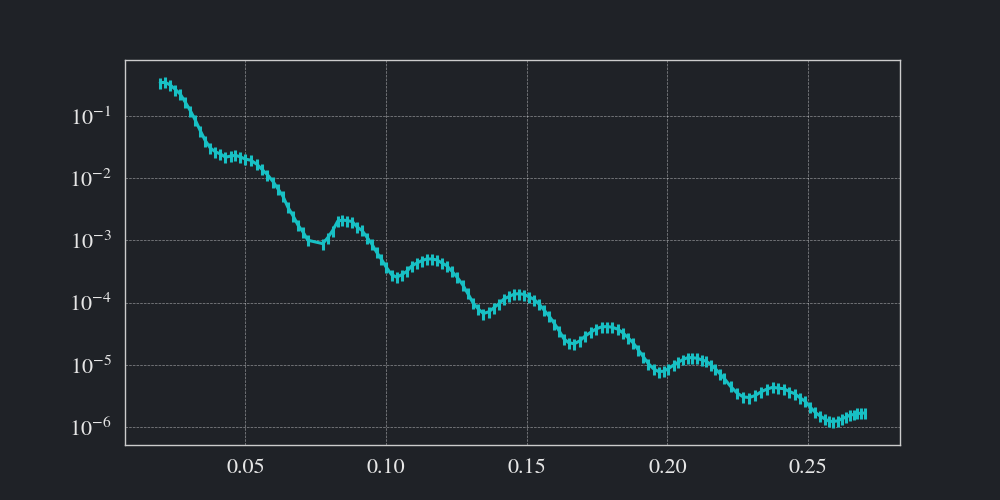

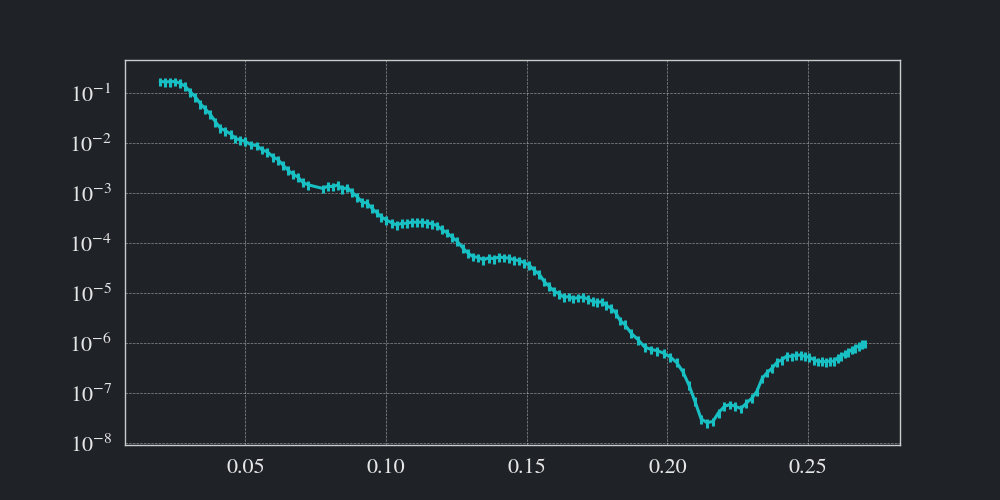

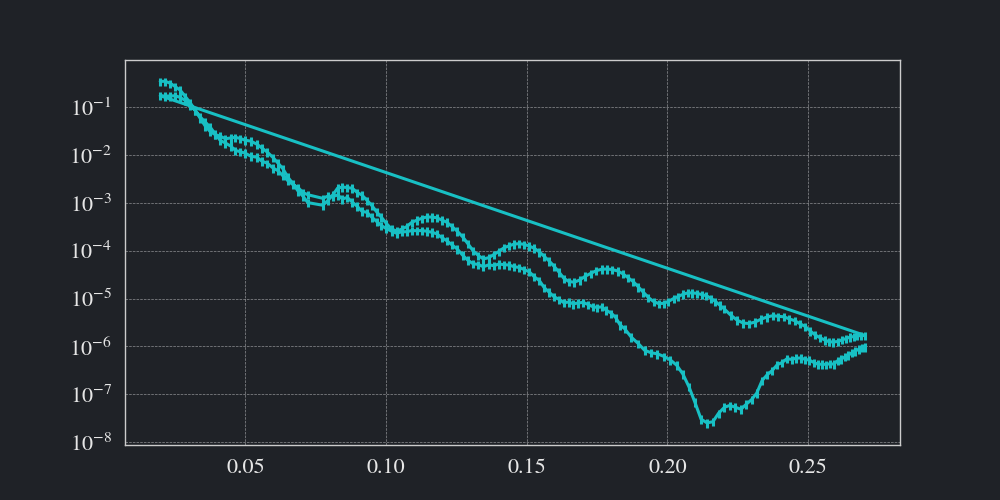

In [22]:
# ------------------------------------------------
# Load Data
# ------------------------------------------------

s_pol_ = s_pol.iloc[10:]
p_pol_ = p_pol.iloc[10:]

s_data = rf.to_refnx_dataset(s_pol_, pol="s", error=0.2)
p_data = rf.to_refnx_dataset(p_pol_, pol="p", error=0.2)

data = rf.to_refnx_dataset(s_pol_, pol="sp", second_pol=p_pol_, error=0.2)

s_data.plot()
plt.yscale("log")
p_data.plot()
plt.yscale("log")
data.plot()
plt.yscale("log")

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

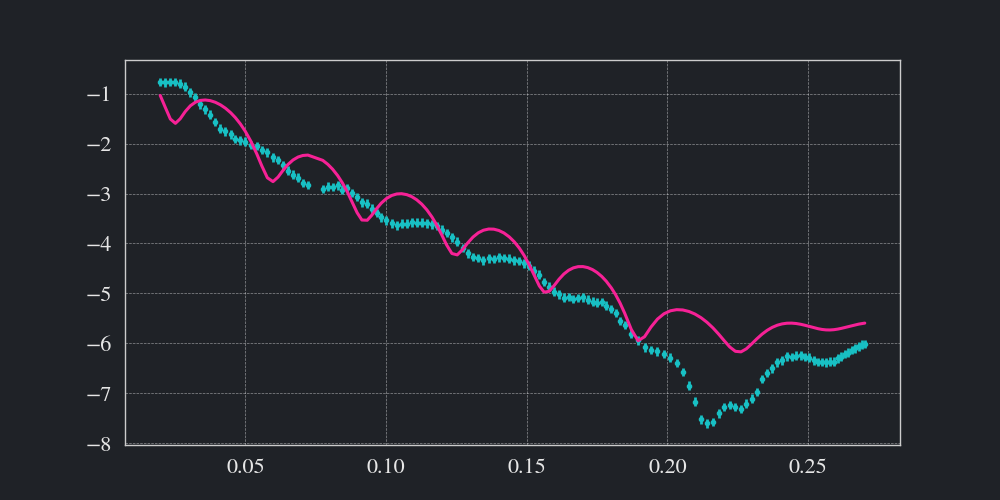

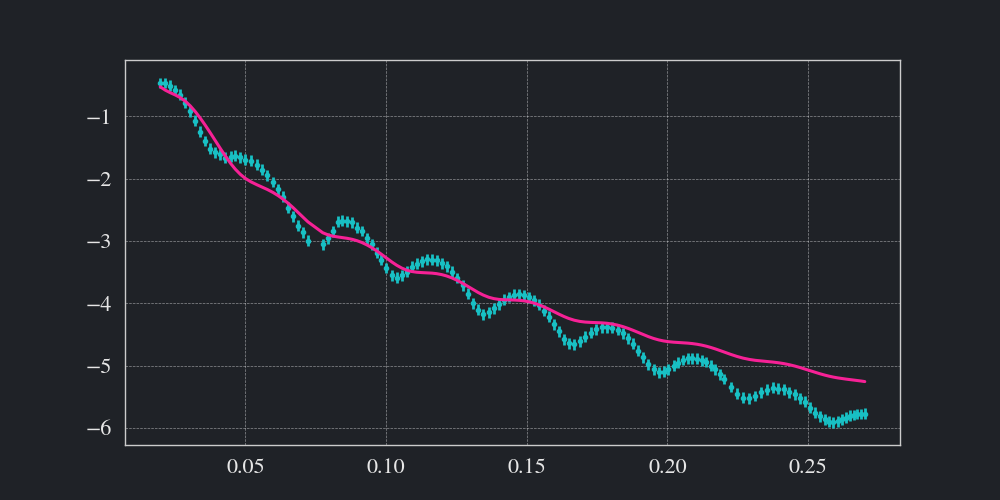

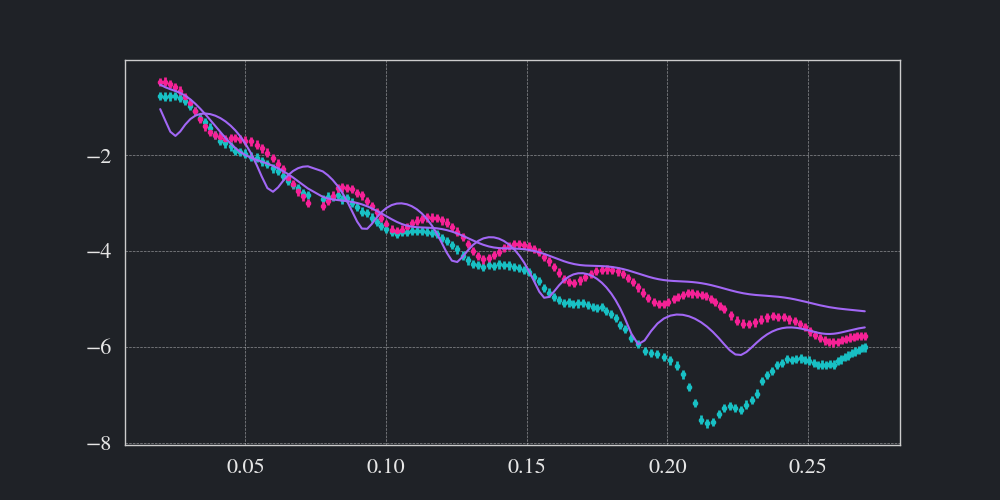

In [23]:
from pyref.fitting.logp import LogpExtra as LogpExtra
# ------------------------------------------------
# p - polarized data
# ------------------------------------------------

p_model = PXR_ReflectModel(
    structs[0],
    pol="p",
    energy=ens[1],
    name="ZnPc Mono Layer",
    theta_offset={"p": 0.1},
    scale={"p": .89},
    bkg={"p": 0},
    en_offset=0,
)

p_model.scale.setp(vary=True, bounds=(0.6, 1.2))
p_model.theta_offset.setp(vary=True, bounds=(-2, 1))

p_obj = Objective(p_model, p_data, transform=Transform("logY"))
lpe = LogpExtra(p_obj)
p_obj.logp_extra = lpe
p_obj.plot()

s_model = PXR_ReflectModel(
    structs[1],
    pol="s",
    energy=ens[0],
    name="ZnPc Mono Layer",
    theta_offset={"s": -0.1},
    scale={"s": 1.3}
)

s_model.theta_offset.setp(vary=True, bounds=(-2, 1))
s_model.en_offset.setp(vary=True, bounds=(-0.5, 0.5))

s_obj = Objective(s_model, s_data, transform=Transform("logY"))
lpe = LogpExtra(s_obj)
s_obj.logp_extra = lpe
s_obj.plot()

obj = GlobalObjective([p_obj, s_obj])
obj.plot()

In [51]:
class Fitter:
    # Suppresses the warning
    from warnings import simplefilter
    simplefilter("ignore")
    def __init__(self, obj: Objective | GlobalObjective, walkers_per_param=10):
        self.obj = obj
        self.move = [
            (DEMove(sigma=1e-7), 0.90),
            (DEMove(sigma=1e-3), 0.05),
            (DEMove(sigma=1e-7, gamma0=1), 0.05),
        ]
        self._n_walkers = walkers_per_param * len(obj.varying_parameters())
        self.fitter = CurveFitter(obj, nwalkers=self._n_walkers, moves=self.move)

    @property
    def n_walkers(self):
        return self._n_walkers

    @n_walkers.setter
    def n_walkers(self, value):
        self._n_walkers = value
        self.fitter = CurveFitter(self.obj, nwalkers=self._n_walkers, moves=self.move)

    def red_chisqr(self):
        return self.obj.chisqr() / (
            len(self.obj.data.data[0]) - len(self.obj.varying_parameters())
        )

    def fit(
        self,
        steps_per_walker=5,
        thin=1,
        seed=1,
        init: Literal["jitter", "prior"] = "jitter",
        show_output=False,
    ):
        steps = steps_per_walker * self.n_walkers
        self.fitter.initialise(init, random_state=seed)
        self.chain = self.fitter.sample(steps, random_state=seed, nthin=thin, nburn=self.n_walkers // 2)

        if show_output:
            print(fr"Reduced χ2 = {self.red_chisqr()}")
            print(self.obj.varying_parameters())
            fig, ax = plt.subplots()
            lp = self.fitter.logpost
            ax.plot(-lp)
            fig.show()
            self.obj.plot(resid=True)
            plt.show()

Output()

Reduced χ2 = 2.8332736529469766
________________________________________________________________________________
Parameters:      None      
<Parameter:    'scale'    , value=0.798857 +/- 0.163, bounds=[0.6, 1.2]>
<Parameter:'theta_offset' , value=-0.558862   +/- 1  , bounds=[-2.0, 1.0]>
<Parameter:'ZnPc_surf_thick', value=9.53276 +/- 1.45 , bounds=[8.0, 12.0]>
<Parameter:'ZnPc_surf_xx' , value=0.000814226 +/- 0.000677, bounds=[-0.005, 0.003]>
<Parameter:'ZnPc_surf_ixx', value=0.000109126 +/- 0.000763, bounds=[-0.005, 0.003]>
<Parameter:'ZnPc_surf_zz' , value=0.000154686 +/- 0.00107, bounds=[-0.005, 0.003]>
<Parameter:'ZnPc_surf_izz', value=0.000310071 +/- 0.00107, bounds=[-0.005, 0.003]>
<Parameter:'ZnPc_surf_rough', value=7.52292 +/- 0.958, bounds=[5.773024, 8.659536]>
<Parameter:   'ZnPc_xx'   , value=0.000252182 +/- 0.000164, bounds=[1.5e-05, 0.0004955200281860432]>
<Parameter:  'ZnPc_ixx'   , value=0.000109258 +/- 6.29e-05, bounds=[1.5e-05, 0.00020494953411908198]>
<Parameter:   '

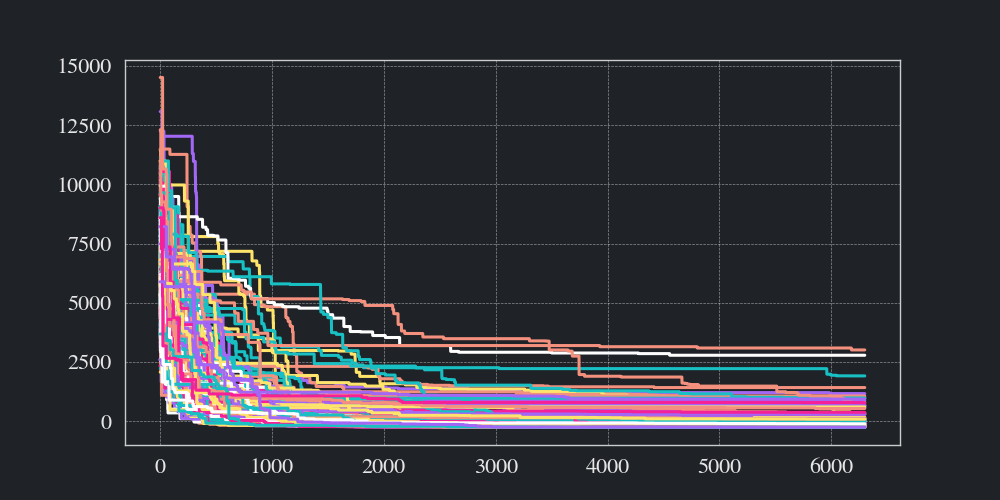

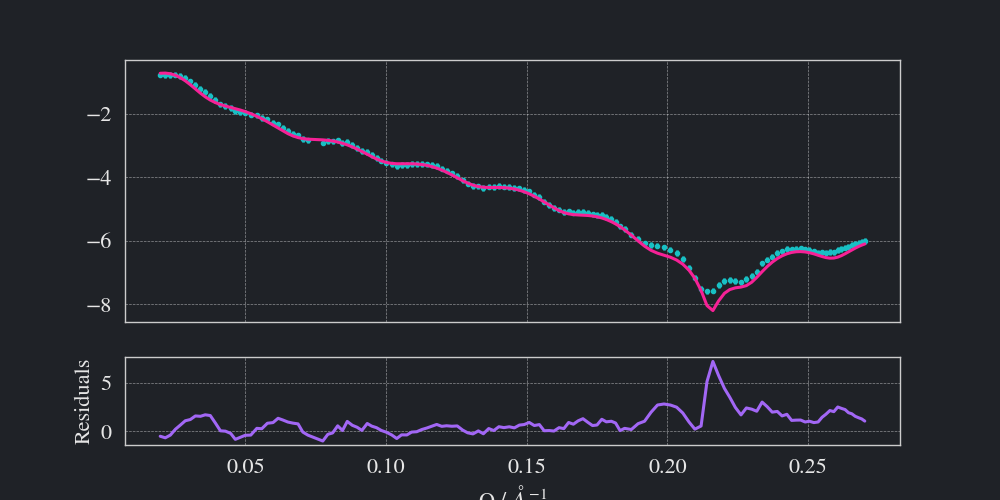

Output()

Reduced χ2 = 4.092517231611803
________________________________________________________________________________
Parameters:      None      
<Parameter:  'en_offset'  , value=-0.00573894 +/- 0.337, bounds=[-0.5, 0.5]>
<Parameter:'theta_offset' , value=-0.531074 +/- 1.03 , bounds=[-2.0, 1.0]>
<Parameter:'ZnPc_surf_ixx', value=0.000598149 +/- 5.68e-05, bounds=[-0.005, 0.003]>
<Parameter:'ZnPc_surf_zz' , value=-0.00100894 +/- 0.0027, bounds=[-0.005, 0.003]>
<Parameter:  'ZnPc_ixx'   , value=0.000202048 +/- 4.4e-06, bounds=[1.5e-05, 0.00020494953411908198]>
<Parameter:   'ZnPc_zz'   , value=-0.00221985 +/- 0.0015, bounds=[-0.004487785909452915, -1.5e-05]>
<Parameter:'ZnPc_sub_ixx' , value=-0.00153401 +/- 6.24e-05, bounds=[-0.005, 0.003]>
<Parameter: 'ZnPc_sub_zz' , value=-0.000985949 +/- 0.00274, bounds=[-0.005, 0.003]>
<Parameter:     'rho'     , value=1.56274 +/- 0.0163, bounds=[1.5516400000000001, 2.32746]>
<Parameter:     'rho'     , value=2.5655 +/- 0.0168, bounds=[1.7172640000000001, 

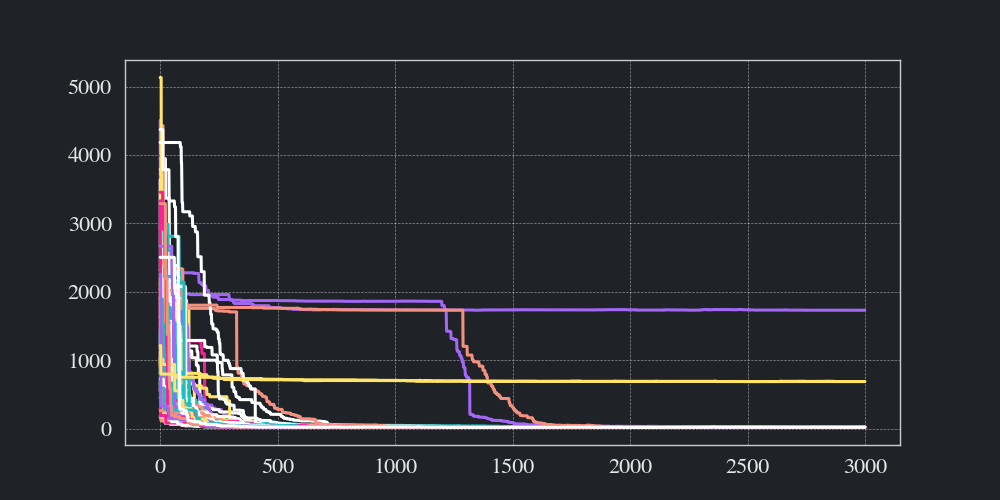

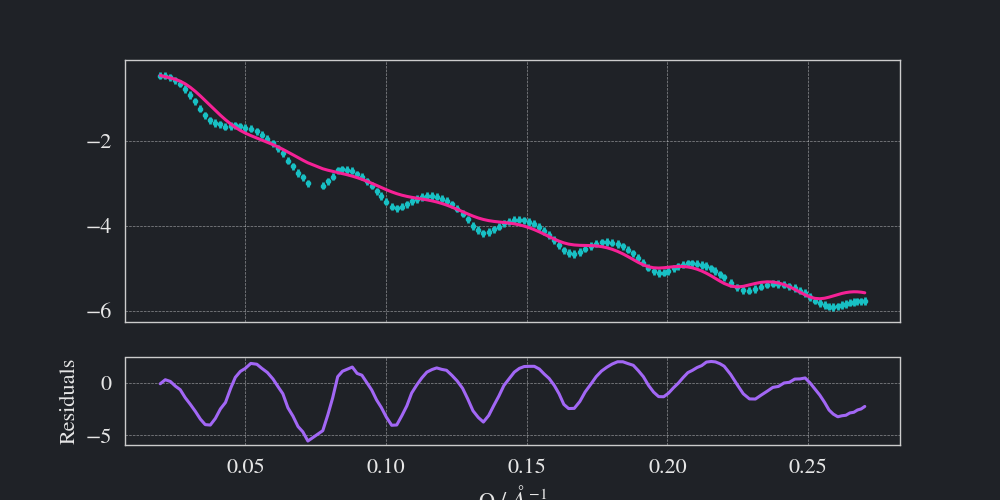

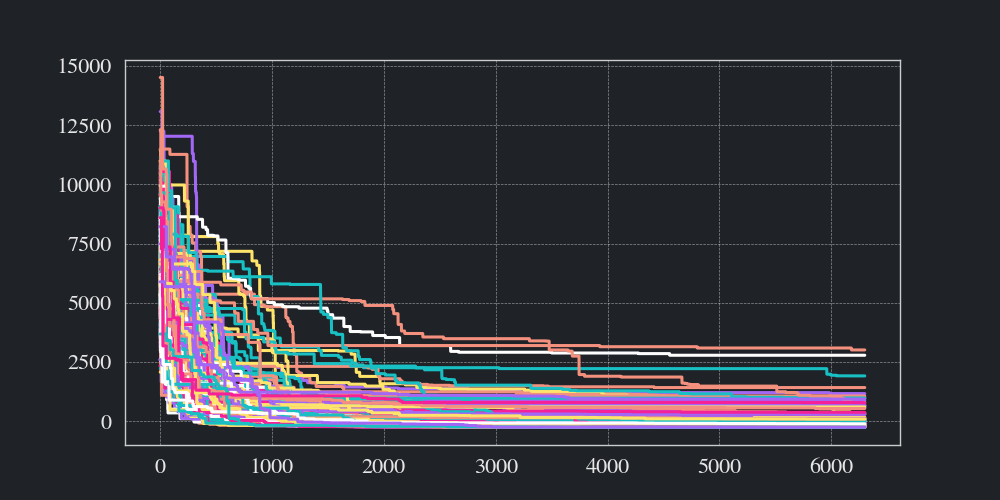

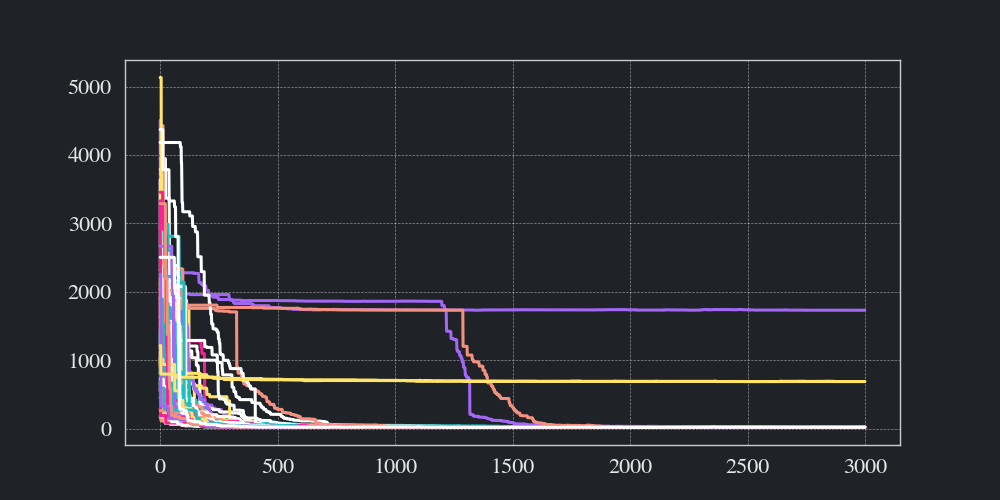

In [52]:
fitter_p = Fitter(p_obj, walkers_per_param=15)
fitter_s = Fitter(s_obj, walkers_per_param=15)

fitter_p.fit(init="prior", steps_per_walker=20, seed=1, show_output=True)
fitter_s.fit(init="prior", steps_per_walker=20, seed=1, show_output=True)

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

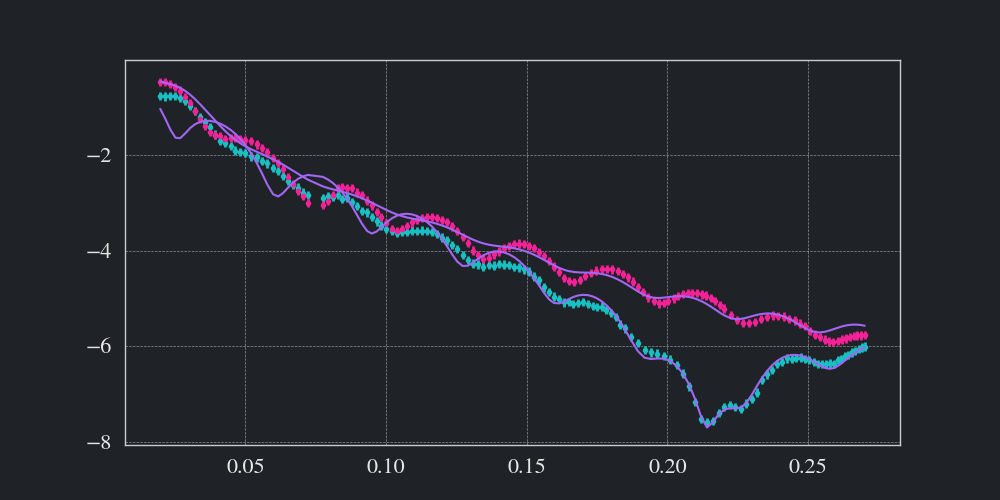

In [13]:
fitter_p.obj.plot()

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='z / $\\AA$', ylabel='Index of refraction'>)

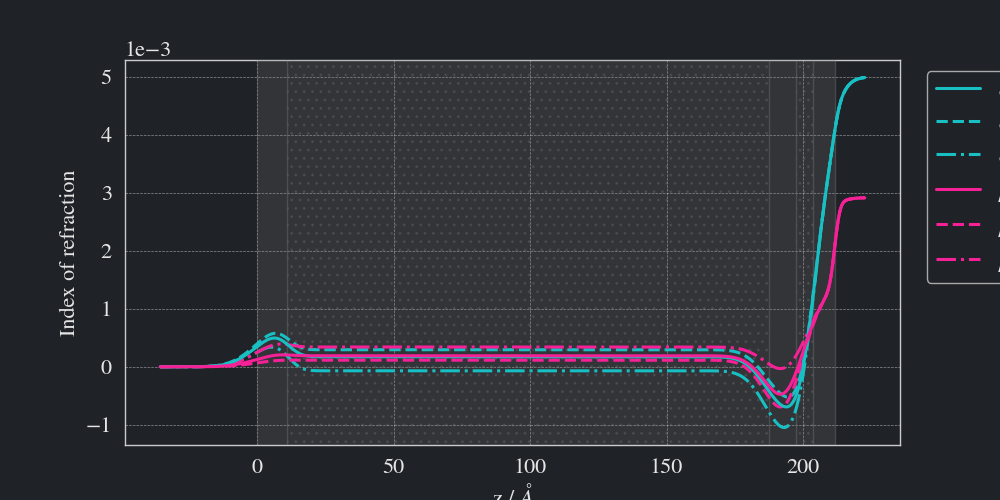

In [14]:
structs[0].plot()

(<Figure size 1000x500 with 1 Axes>, <Axes: >)

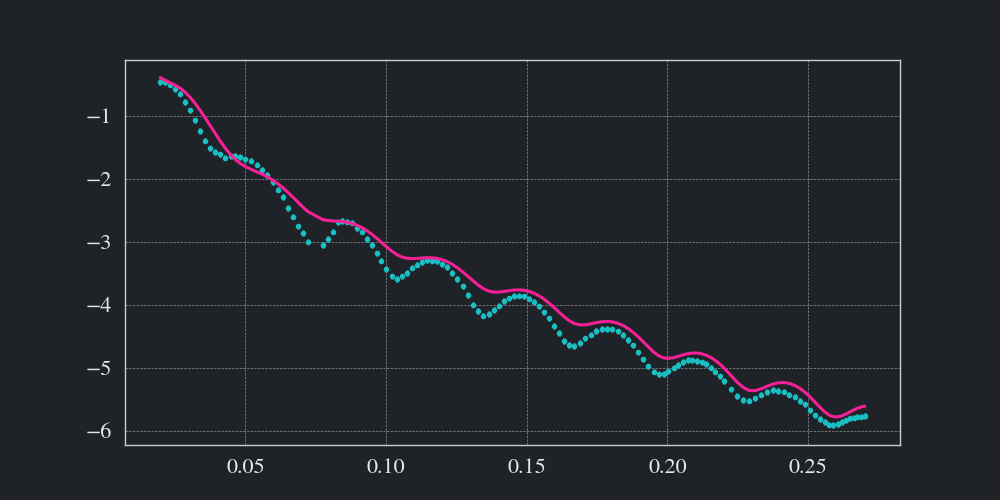

Output()

Reduced χ2 = 5.958624224940706
--------------------------------------------------


Output()

Reduced χ2 = 4.708978660613476
--------------------------------------------------


Output()

Reduced χ2 = 4.685897336190486
--------------------------------------------------
________________________________________________________________________________
Parameters:      None      
<Parameter:  'en_offset'  , value=0.0261526 +/- 0.288, bounds=[-0.5, 0.5]>
<Parameter:    'scale'    , value=0.956483 +/- 0.02 , bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=1.41526e-08 +/- 8.39e-09, bounds=[1e-12, 2.5316362333630955e-08]>
<Parameter:'theta_offset' , value=-0.527341 +/- 0.977, bounds=[-2.0, 1.0]>
<Parameter:'ZnPc_surf_thick', value=11.9534 +/- 0.0534, bounds=[8.0, 12.0]>
<Parameter:'ZnPc_surf_xx' , value=0.00107306 +/- 4.43e-05, bounds=[-0.005, 0.003]>
<Parameter:'ZnPc_surf_ixx', value=0.000457051 +/- 8.51e-05, bounds=[-0.005, 0.003]>
<Parameter:'ZnPc_surf_zz' , value=-0.00106488 +/- 0.00261, bounds=[-0.005, 0.003]>
<Parameter:'ZnPc_surf_izz', value=-0.000927376 +/- 0.00252, bounds=[-0.005, 0.003]>
<Parameter:'ZnPc_surf_rough', value=8.58859 +/- 0.0808, bounds=[5.773024, 8.

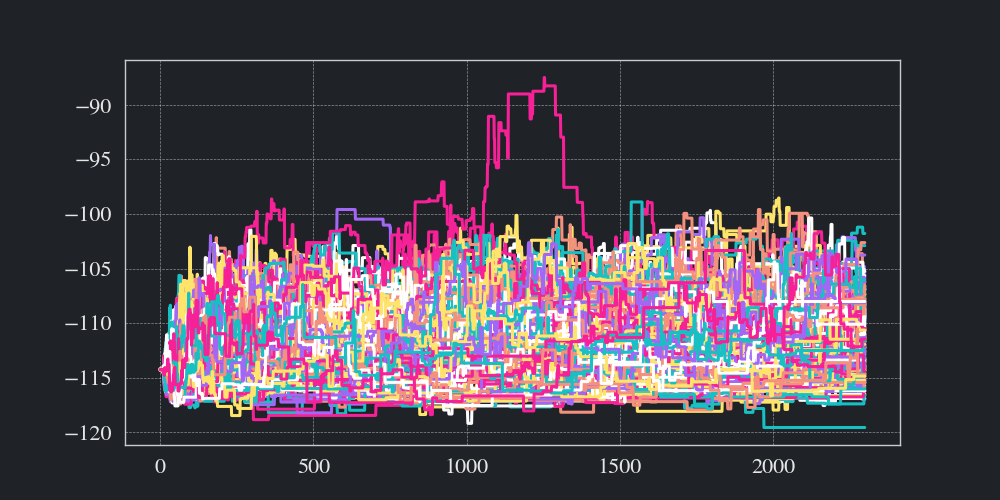

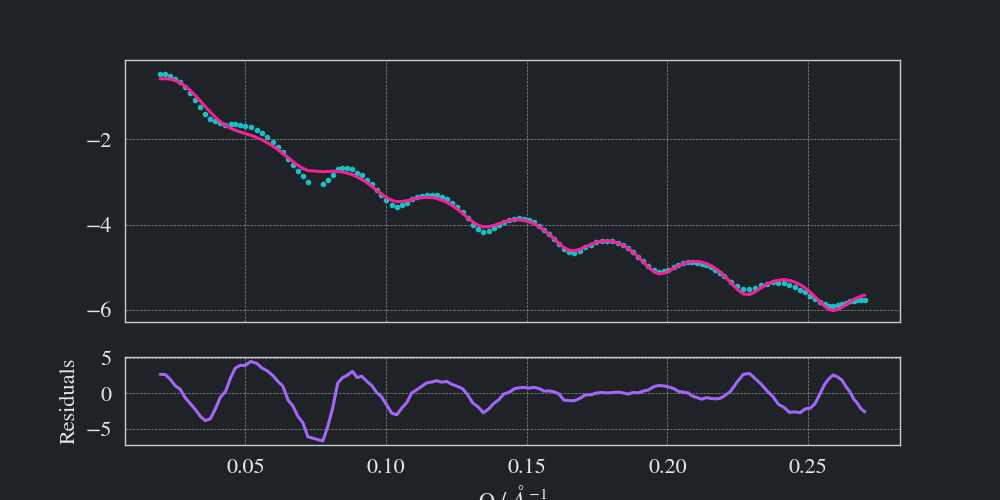

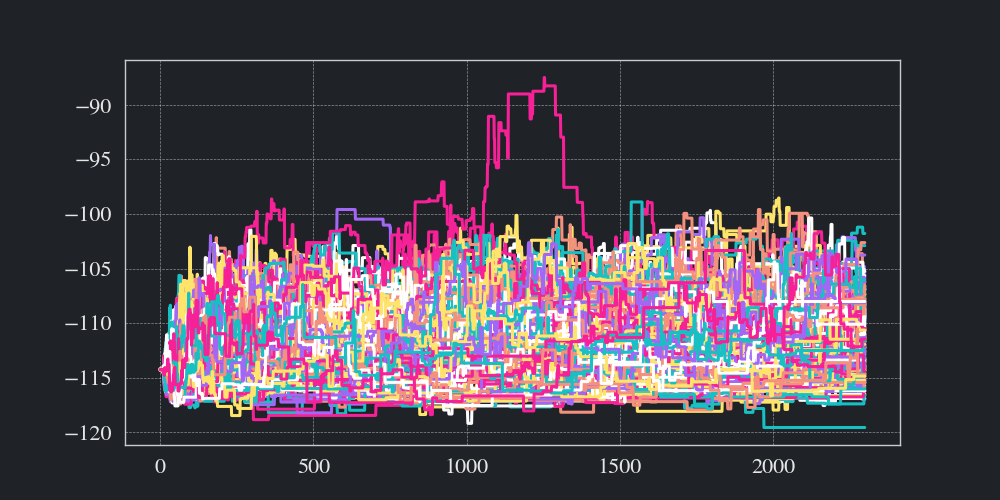

In [43]:
fitter_s = Fitter(s_obj, walkers_per_param=10)
fitter_s.fit(init="prior", steps_per_walker=10)
fitter_s.fit(init="jitter", steps_per_walker=10)
fitter_s.err = .1
fitter_s.fit(init="jitter", steps_per_walker=10, show_output=True)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='z / $\\AA$', ylabel='Index of refraction'>)

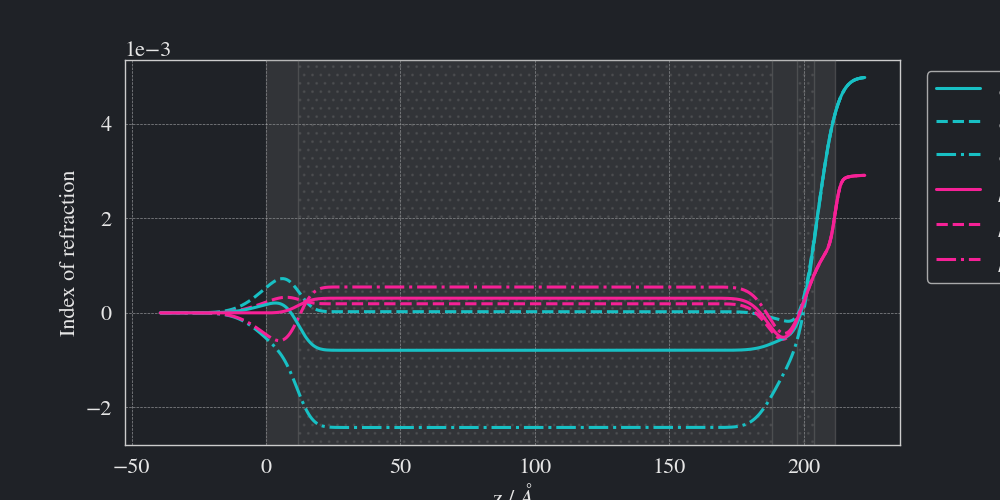

In [44]:
structs[0].plot()

  0%|          | 0/1800 [00:00<?, ?it/s]c:\Users\hduva\micromamba\envs\refl\Lib\site-packages\refnx\_lib\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 1800/1800 [04:07<00:00,  7.28it/s]


________________________________________________________________________________
Parameters:      None      
<Parameter:  'en_offset'  , value=-0.00241178 +/- 0.326, bounds=[-0.5, 0.5]>
<Parameter:    'scale'    , value=0.839877 +/- 0.17 , bounds=[0.6, 1.2]>
<Parameter:     'bkg'     , value=1.23828e-08 +/- 8.41e-09, bounds=[1e-12, 2.5316362333630955e-08]>
<Parameter:'theta_offset' , value=-0.541222 +/- 1.02 , bounds=[-2.0, 1.0]>
<Parameter:'ZnPc_surf_thick', value=10.3547 +/- 1.21 , bounds=[8.0, 12.0]>
<Parameter:'ZnPc_surf_xx' , value=-4.05556e-05 +/- 0.00124, bounds=[-0.005, 0.005]>
<Parameter:'ZnPc_surf_ixx', value=0.000811364 +/- 0.000762, bounds=[0.0, 0.003]>
<Parameter:'ZnPc_surf_zz' , value=-0.00134769 +/- 0.00132, bounds=[-0.005, 0.005]>
<Parameter:'ZnPc_surf_izz', value=0.000830818 +/- 0.000749, bounds=[0.0, 0.003]>
<Parameter:'ZnPc_surf_rough', value=7.06204 +/- 0.898, bounds=[5.773024, 8.659536]>
<Parameter: 'ZnPc_thick'  , value=176.662 +/- 19.7 , bounds=[149.1528, 223.729

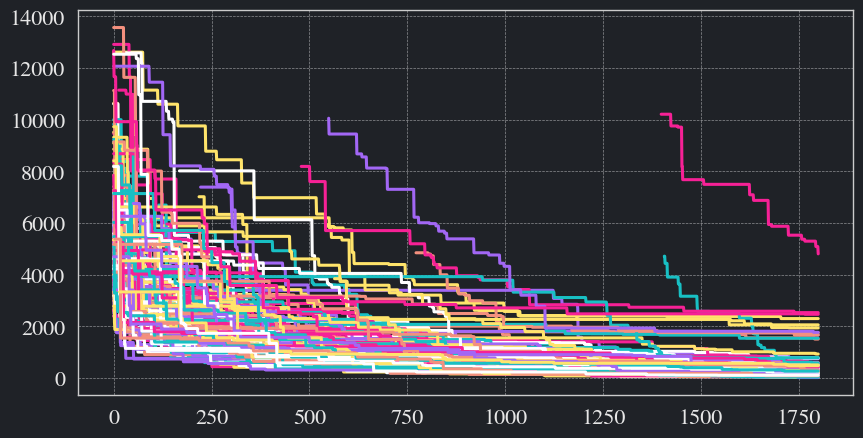

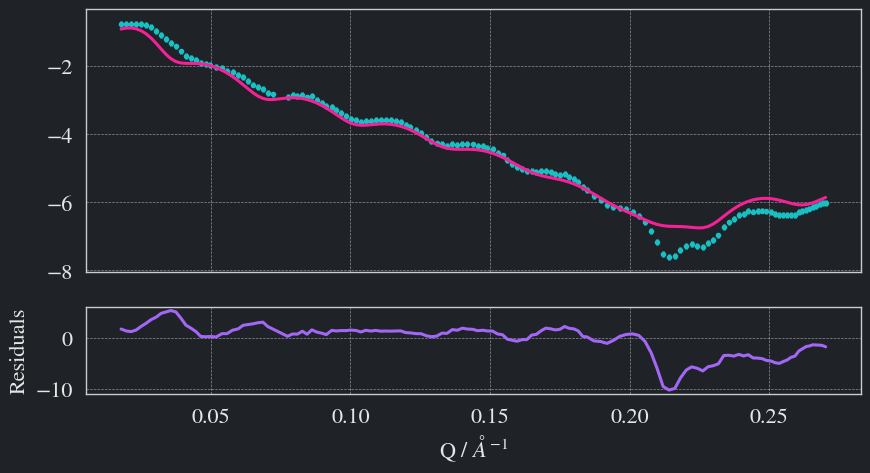

In [53]:
fitter_func(p_obj, steps_per_walker=10, thin=1, seed=1)

(<Figure size 1000x500 with 1 Axes>,
 <Axes: xlabel='z / $\\AA$', ylabel='Index of refraction'>)

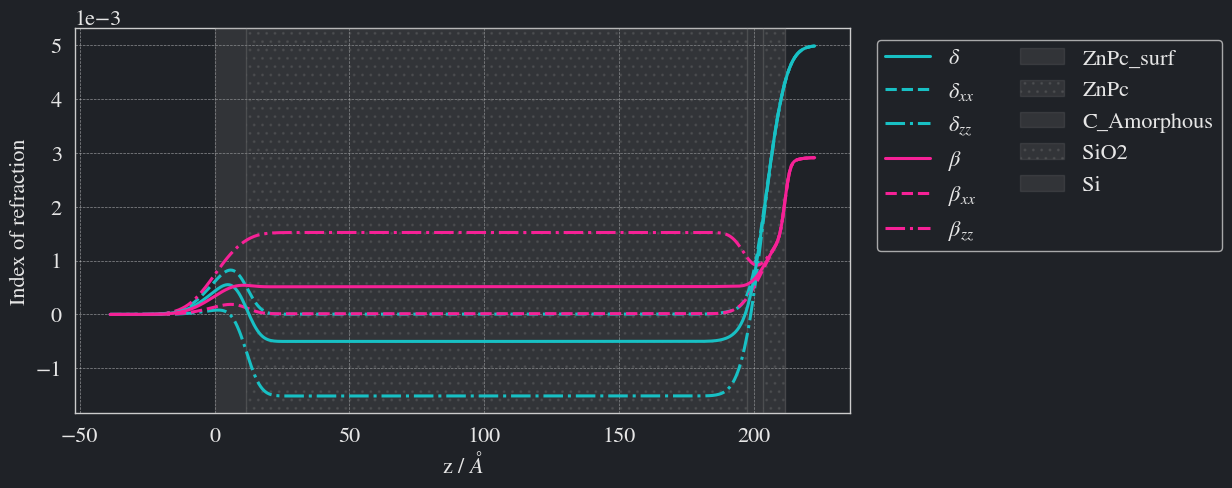

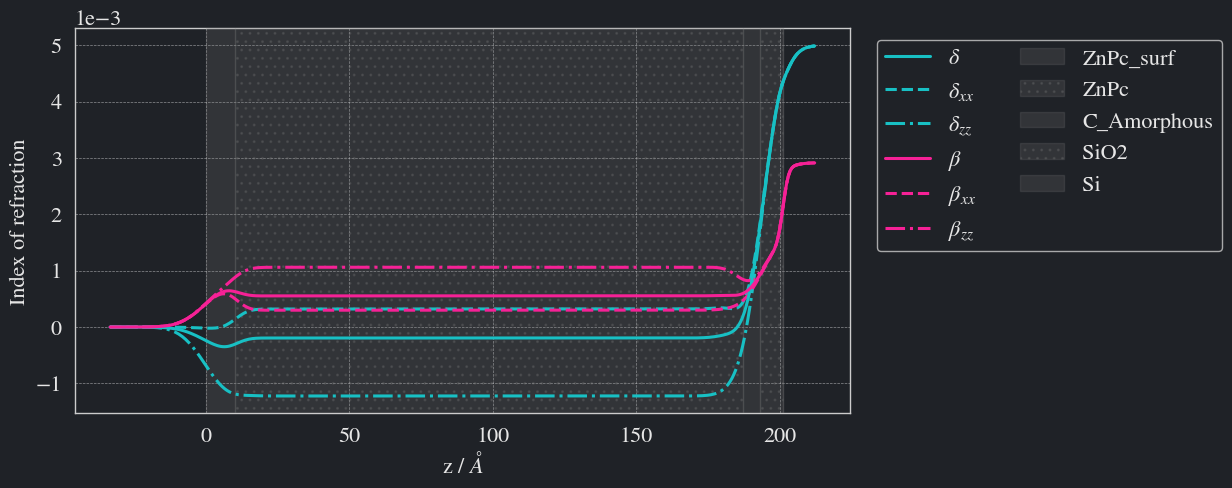

In [54]:
structs[1].plot()
structs[0].plot()

In [11]:
n_walkers = int(10*len(obj_p.varying_parameters()))
steps = 5*n_walkers

move = [(DEMove(sigma=1e-7), 0.95), (DEMove(sigma=1e-7, gamma0=1), 0.05)]
random_state = 120

fitter = CurveFitter(obj_p, nwalkers=n_walkers, moves = move)
fitter.initialise("prior")
chain = fitter.sample(steps, random_state=random_state)

lp = fitter.logpost
plt.plot(-lp)
plt.show()
structs[0].plot(difference=True)

print(obj_p.varying_parameters())
print(obj_p.chisqr() / (len(p_data.data[0]) - len(obj_p.varying_parameters())))
obj_p.plot()

NameError: name 'obj_p' is not defined